<a href="https://colab.research.google.com/github/vandujain/NLP-Workshop/blob/main/NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# utilities
import re
import numpy as np
import pandas as pd
# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# nltk
from nltk.stem import WordNetLemmatizer
# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

In [7]:
# Importing the dataset
DATASET_COLUMNS=['target','ids','date','flag','user','text']
DATASET_ENCODING = "ISO-8859-1"
df = pd.read_csv('/training.1600000.processed.noemoticon.csv', encoding=DATASET_ENCODING, names=DATASET_COLUMNS)
df.sample(5)

,target,ids,date,flag,user,text
966876,4,1827730873,Sun May 17 11:19:39 PDT 2009,NO_QUERY,elmvb1,"@tidyamy You, for instance."
448038,0,2068855222,Sun Jun 07 14:49:21 PDT 2009,NO_QUERY,pixiepurls,spider on my FREAKING LAPTOP OMG IN THE KEYBOA...
122240,0,1833672994,Mon May 18 00:03:38 PDT 2009,NO_QUERY,blakycomanse09,i hope I'm not in trouble i left a sad comment...
1032115,4,1933151637,Tue May 26 23:07:50 PDT 2009,NO_QUERY,Danii92,Chillin's at home listenin to sum DOLL DOMINAT...
1347436,4,2044576425,Fri Jun 05 09:33:13 PDT 2009,NO_QUERY,JBTrades,@ForeverCaroline pls make $HEB go up


EXPLORATORY DATA ANALYSIS

In [17]:
df.shape

(1600000, 6)

In [8]:
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [11]:
df.columns

Index(['target', 'ids', 'date', 'flag', 'user', 'text'], dtype='object')

In [10]:
print('length of data is', len(df))

length of data is 1600000


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [18]:
df.describe()

,target,ids
count,1.600000e+06,1.600000e+06
mean,2.000000e+00,1.998818e+09
std,2.000001e+00,1.935761e+08
min,0.000000e+00,1.467810e+09
25%,0.000000e+00,1.956916e+09
50%,2.000000e+00,2.002102e+09
75%,4.000000e+00,2.177059e+09
max,4.000000e+00,2.329206e+09


In [14]:
df.dtypes

,0
target,int64
ids,int64
date,object
flag,object
user,object
text,object


In [19]:
df.isnull().sum()

,0
target,0
ids,0
date,0
flag,0
user,0
text,0


In [20]:
df['target'].unique()

array([0, 4])

In [21]:
df.duplicated().sum()

0

In [15]:
np.sum(df.isnull().any(axis=1))

0

In [16]:
print('Count of columns in the data is:  ', len(df.columns))
print('Count of rows in the data is:  ', len(df))

Count of columns in the data is:   6
Count of rows in the data is:   1600000


DATA VISUALIZATION OF TARGET VARIABLE

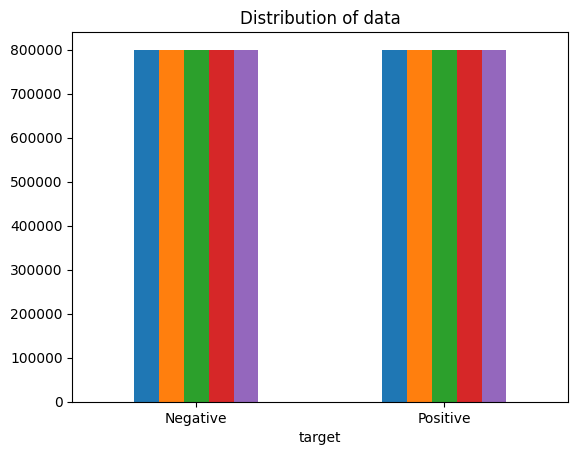

In [22]:
# Plotting the distribution for dataset.
ax = df.groupby('target').count().plot(kind='bar', title='Distribution of data',legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)
# Storing data in lists.
text, sentiment = list(df['text']), list(df['target'])

<Axes: xlabel='target', ylabel='count'>

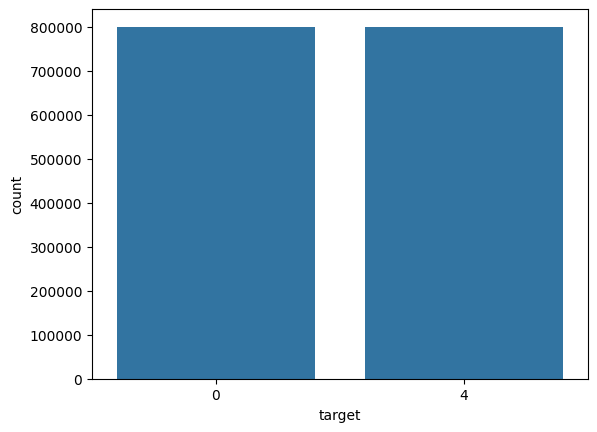

In [23]:
import seaborn as sns
sns.countplot(x='target', data=df)

<Axes: >

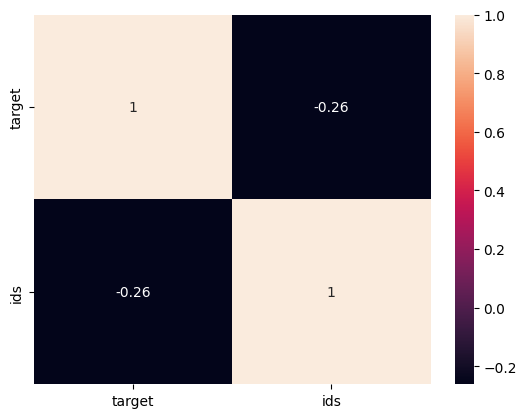

In [25]:
numerical_df = df.select_dtypes(include=['number'])
corr_matrix = numerical_df.corr()
sns.heatmap(corr_matrix, annot=True)

DATA PREPROCESSING

In [27]:
data=df[['text','target']]

In [28]:
data['target'] = data['target'].replace(4,1)

<ipython-input-28-54c9eb4fa536>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['target'] = data['target'].replace(4,1)


In [29]:
data['target'].unique()

array([0, 1])

In [30]:
data_pos = data[data['target'] == 1]
data_neg = data[data['target'] == 0]

In [31]:
data_pos = data_pos.iloc[:int(20000)]
data_neg = data_neg.iloc[:int(20000)]

In [32]:
dataset = pd.concat([data_pos, data_neg])

In [33]:
dataset['text']=dataset['text'].str.lower()
dataset['text'].tail()

,text
19995,"not much time off this weekend, work trip to m..."
19996,one more day of holidays
19997,feeling so down right now .. i hate you damn h...
19998,"geez,i hv to read the whole book of personalit..."
19999,i threw my sign at donnie and he bent over to ...


In [34]:
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [35]:
STOPWORDS = set(stopwordlist)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
dataset['text'] = dataset['text'].apply(lambda text: cleaning_stopwords(text))
dataset['text'].head()

,text
800000,love @health4uandpets u guys r best!!
800001,im meeting one besties tonight! cant wait!! - ...
800002,"@darealsunisakim thanks twitter add, sunisa! g..."
800003,sick really cheap hurts much eat real food plu...
800004,@lovesbrooklyn2 effect everyone


In [36]:
import string
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
dataset['text']= dataset['text'].apply(lambda x: cleaning_punctuations(x))
dataset['text'].tail()

,text
19995,not much time off weekend work trip malmï¿½ fr...
19996,one day holidays
19997,feeling right hate damn humprey
19998,geezi hv read whole book personality types emb...
19999,threw sign donnie bent over get but thingee ma...


In [37]:
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_repeating_char(x))
dataset['text'].tail()

,text
19995,not much time off weekend work trip malmï¿½ fr...
19996,one day holidays
19997,feeling right hate damn humprey
19998,geezi hv read whole book personality types emb...
19999,threw sign donnie bent over get but thingee ma...


In [38]:
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_URLs(x))
dataset['text'].tail()

,text
19995,not much time off weekend work trip malmï¿½ fr...
19996,one day holidays
19997,feeling right hate damn humprey
19998,geezi hv read whole book personality types emb...
19999,threw sign donnie bent over get but thingee ma...


In [39]:
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_numbers(x))
dataset['text'].tail()

,text
19995,not much time off weekend work trip malmï¿½ fr...
19996,one day holidays
19997,feeling right hate damn humprey
19998,geezi hv read whole book personality types emb...
19999,threw sign donnie bent over get but thingee ma...


In [40]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'w+')
dataset['text'] = dataset['text'].apply(tokenizer.tokenize)
dataset['text'].head()

,text
800000,[]
800001,[w]
800002,"[w, w, w]"
800003,[]
800004,[]


In [41]:
import nltk
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data
dataset['text']= dataset['text'].apply(lambda x: stemming_on_text(x))
dataset['text'].head()

,text
800000,[]
800001,[w]
800002,"[w, w, w]"
800003,[]
800004,[]


In [42]:
import nltk

nltk.download('wordnet')
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data
dataset['text'] = dataset['text'].apply(lambda x: lemmatizer_on_text(x))
dataset['text'].head()

[nltk_data] Downloading package wordnet to /root/nltk_data...


,text
800000,[]
800001,[w]
800002,"[w, w, w]"
800003,[]
800004,[]


In [43]:
X=data.text
y=data.target

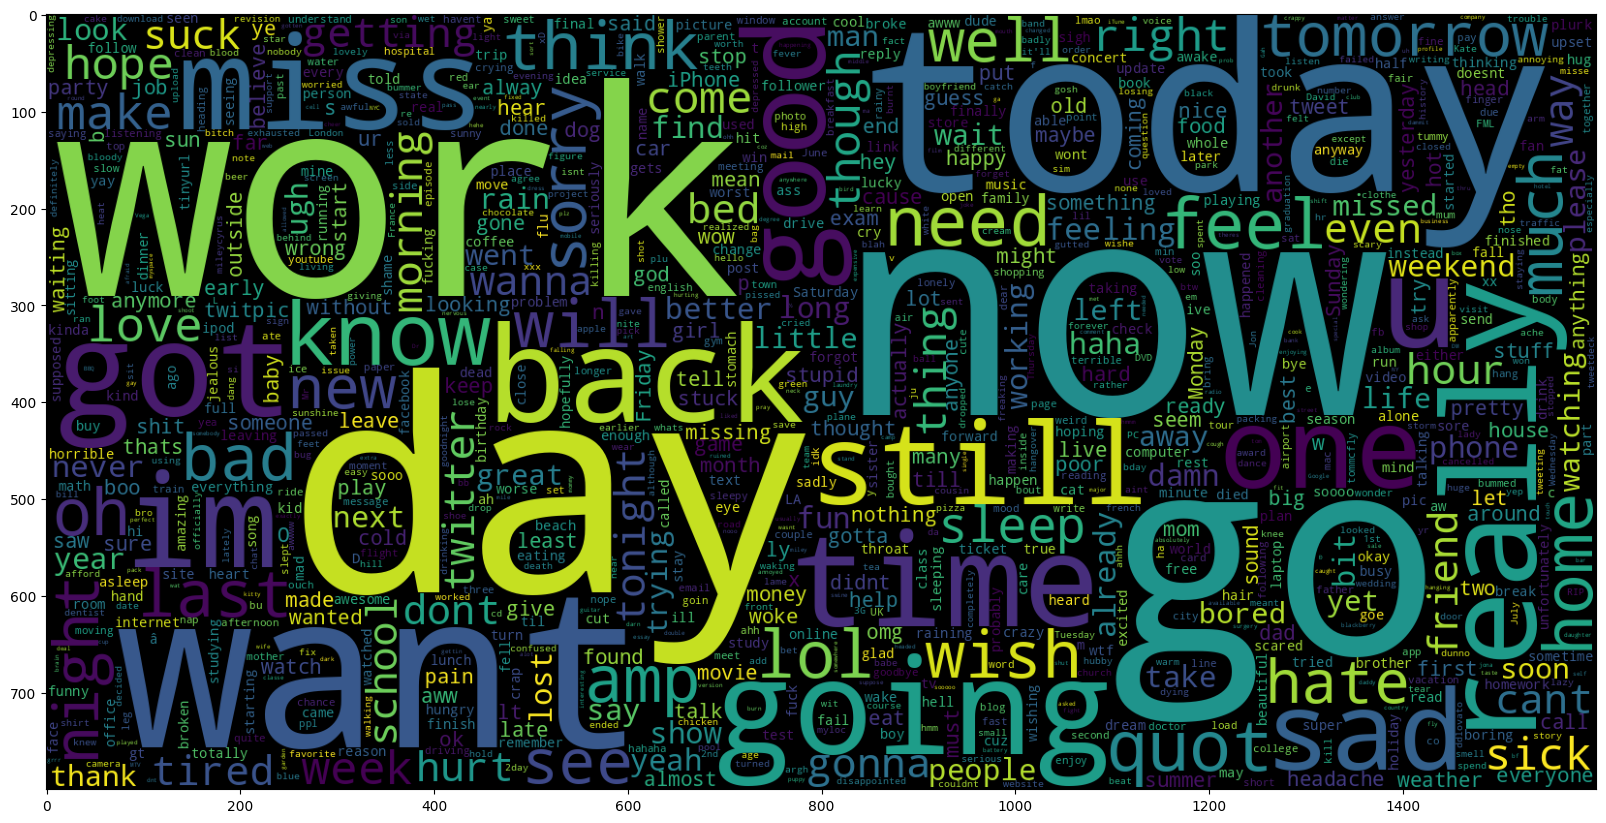

In [44]:
data_neg = data['text'][:800000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

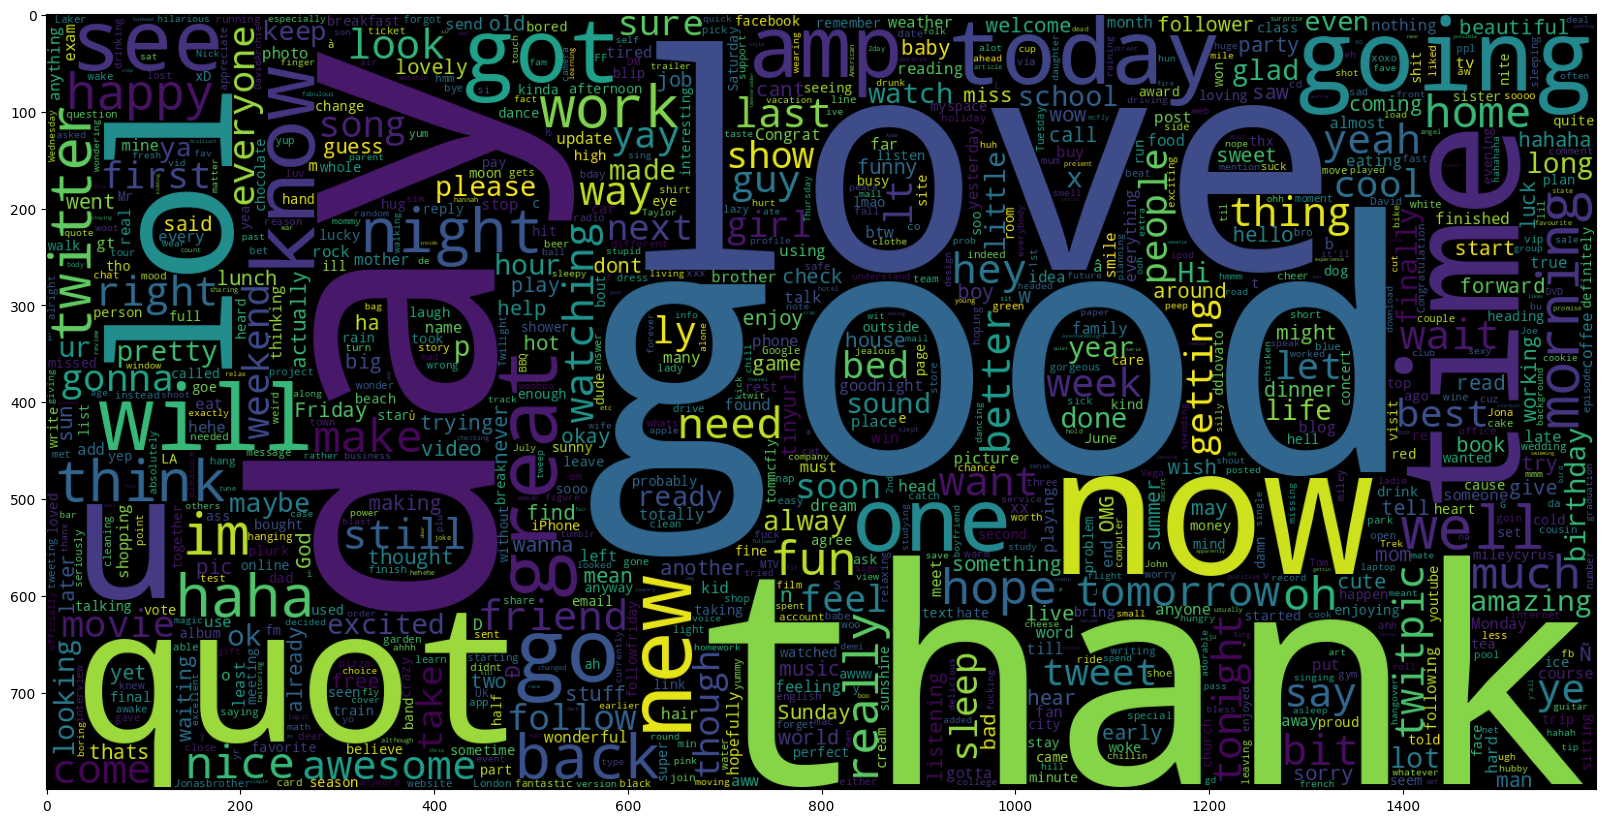

In [45]:
data_pos = data['text'][800000:]
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)

SPLITTING DATA INTO TEST AND TRAIN



In [46]:
# Separating the 90% data for training data and 5% for testing data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.1, random_state =26105111)

In [47]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print('No. of feature_words: ', len(vectoriser.get_feature_names_out()))

No. of feature_words:  500000


In [48]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

MODEL EVALUATION

In [49]:
def model_Evaluate(model):
# Predict values for Test dataset
  y_pred = model.predict(X_test)
# Print the evaluation metrics for the dataset.
  print(classification_report(y_test, y_pred))
# Compute and plot the Confusion matrix
  cf_matrix = confusion_matrix(y_test, y_pred)
  categories = ['Negative','Positive']
  group_names = ['True Neg','False Pos', 'False Neg','True Pos']
  group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
  labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
  xticklabels = categories, yticklabels = categories)
  plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
  plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
  plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

              precision    recall  f1-score   support

           0       0.83      0.81      0.82     80200
           1       0.82      0.83      0.82     79800

    accuracy                           0.82    160000
   macro avg       0.82      0.82      0.82    160000
weighted avg       0.82      0.82      0.82    160000



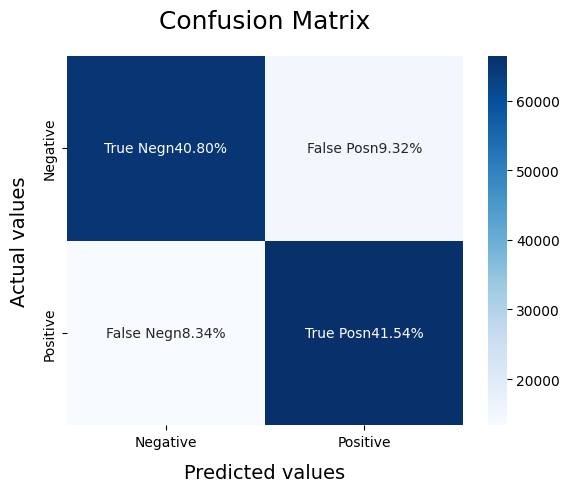

In [50]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)
y_pred = LRmodel.predict(X_test)

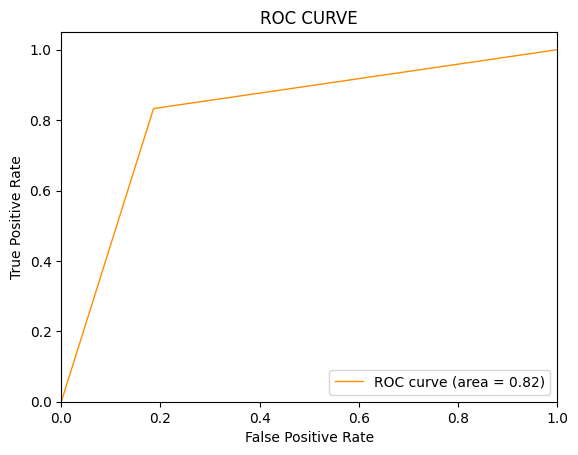

In [51]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

SPEECH OUTPUT

In [52]:
!pip install gTTS

In [53]:
from gtts import gTTS #Import Google Text to Speech
from IPython.display import Audio #Import Audio method from IPython's Display Class
tts = gTTS('The accuracy for regression model has come out to be 82 percent') #Provide the string to convert to speech
tts.save('1.wav') #save the string converted to speech as a .wav file
sound_file = '1.wav'
Audio(sound_file, autoplay=True)

#Autoplay = True will play the sound automatically
#If you would not like to play the sound automatically, simply pass Autoplay = False.